In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(0)
np.random.seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [6]:
# 2D Gaussian Mixture Model

radius = 3.0
means = torch.tensor([
    [ radius, 0.0],
    [ 0.0,  radius],
    [-radius, 0.0],
    [ 0.0, -radius],
    [ 0.0,  0.0],
], dtype=torch.float32)

stds = torch.tensor([0.15, 0.15, 0.15, 0.15, 0.20], dtype=torch.float32)
weights = torch.ones(len(means)) / len(means)

def sample_gmm(n_samples):
    
    comp_idx = torch.multinomial(weights, num_samples=n_samples, replacement=True)
    x = torch.zeros(n_samples, 2)
    for k in range(len(means)):
        mask = (comp_idx == k)
        if mask.any():
            x[mask] = means[k] + stds[k] * torch.randn(mask.sum(), 2)
    return x

In [3]:

def c_gamma(gamma, a=0.8, lam=4.0):
    c = torch.where(gamma <= a, torch.ones_like(gamma),
                    (1 - gamma) / (1 - a))
    return lam * c


def sample_eqm_batch(n_samples):
   
    x = sample_gmm(n_samples)
    eps = torch.randn_like(x)
    gamma = torch.rand(n_samples, 1)
    
    x_gamma = gamma * x + (1 - gamma) * eps
    c = c_gamma(gamma)
    target = (eps - x) * c
    
    return x, eps, gamma, x_gamma, target

In [4]:
class EqMField(nn.Module):
    def __init__(self, hidden_dim=128, num_layers=3):
        super().__init__()
        layers = []
        in_dim, out_dim = 2, 2

        dims = [in_dim] + [hidden_dim] * num_layers + [out_dim]
        for i in range(len(dims) - 2):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            layers.append(nn.GELU())
        layers.append(nn.Linear(dims[-2], dims[-1]))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)
    
f_theta = EqMField(hidden_dim=128, num_layers=3).to(device)
optimizer = optim.Adam(f_theta.parameters(), lr=1e-3)

In [7]:
epochs = 2000          
batch_size = 512

for step in range(epochs):
    x, eps, gamma, x_gamma, target = sample_eqm_batch(batch_size)
    x_gamma, target = x_gamma.to(device), target.to(device)
    
    pred = f_theta(x_gamma)
    loss = ((pred - target) ** 2).sum(dim=1).mean()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step % 200 == 0:
        print(f"Step {step:05d} | Loss: {loss.item():.5f}")

Step 00000 | Loss: 133.73196
Step 00200 | Loss: 98.54976
Step 00400 | Loss: 100.02444
Step 00600 | Loss: 99.04999
Step 00800 | Loss: 84.44086
Step 01000 | Loss: 87.34717
Step 01200 | Loss: 92.82208
Step 01400 | Loss: 88.81778
Step 01600 | Loss: 93.75162
Step 01800 | Loss: 90.81893


In [ ]:
def sample_from_field(f_model, n_samples=4000, n_steps=500, eta=0.03, g_min=0.02):
   
    x = torch.randn(n_samples, 2, device=device)
    for k in range(n_steps):
        g = f_model(x)
        x = x - eta * g
        if g.norm(dim=1).mean() < g_min:
            break
    return x.cpu()


samples = sample_from_field(f_theta, n_samples=4000, n_steps=600, eta=0.03)



Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


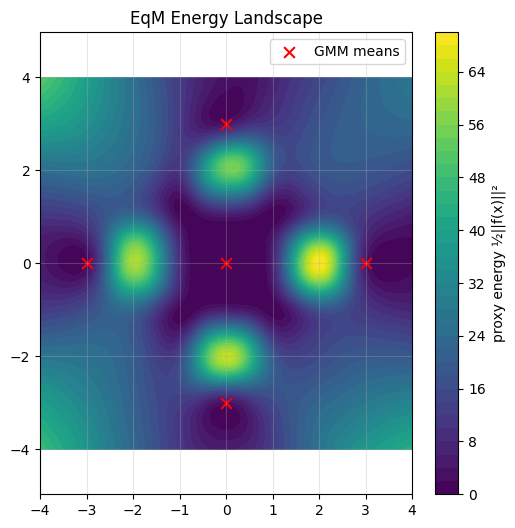

In [ ]:
@torch.no_grad()
def plot_energy_contours(f_model, xrange=(-4, 4), yrange=(-4, 4), density=150):
   
    xs = torch.linspace(xrange[0], xrange[1], density)
    ys = torch.linspace(yrange[0], yrange[1], density)
    X, Y = torch.meshgrid(xs, ys, indexing="xy")
    grid = torch.stack([X.flatten(), Y.flatten()], dim=1).to(device)

    F = f_model(grid)
    energy = 0.5 * (F ** 2).sum(dim=1)
    Z = energy.view(density, density).cpu().numpy()

    plt.figure(figsize=(6, 6))
    plt.contourf(X.cpu(), Y.cpu(), Z, levels=40, cmap="viridis")
    plt.scatter(means[:,0], means[:,1], c="red", s=60, marker="x", label="GMM means")
    plt.axis("equal")
    plt.xlim(xrange)
    plt.ylim(yrange)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.title("EqM Energy Landscape")
    plt.show()

# Plot
plot_energy_contours(f_theta, xrange=(-4, 4), yrange=(-4, 4))